# **Mediapipe To Mixamo**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import json
from IPython.display import clear_output

## **Draw mediapipe function**

In [14]:
def draw_all_frame_mediapipe(json_object):
  for fidx in range(0, len(json_object['frames'])):
    clear_output(wait=True)
    dot1 = []
    for idx in range(0, 33):
      landmark = json_object['frames'][fidx]["keypoints3D"][idx];
      dot1.append([landmark['x'], landmark['y'], landmark['z']])
      if idx < 10: 
        dot1[idx].append('r')
      elif idx == 24 or idx == 23 or idx == 11 or idx == 12:
        dot1[idx].append('b')
      else:
        dot1[idx].append('g')
      dot1[idx].append('o')
    dot1.append([0.0, 0.0, 0.0, 'b', 'H'])


    fig = plt.figure()  
    ax1 = plt.axes(projection='3d')
    ax1.view_init(elev=10, azim=0)
    ax1.set_xlim(-1.0, 1.0) 
    ax1.set_xlabel("x") 
    ax1.set_ylim(-1.0, 1.0)  
    ax1.set_ylabel("y") 
    ax1.set_zlim(-1.0, 1.0)  
    ax1.set_zlabel("z") 
    color1 = ['r', 'g', 'b', 'k', 'm']
    marker1 = ['o', 'v', '1', 's', 'H']
    i = 0
    for x in dot1:
      ax1.scatter3D(x[0],x[1],x[2], c=x[3],
                  marker= x[4], linewidths=1)  
      i += 1
    plt.show()

def draw_mediapipe(json_object, fidx):
  dot1 = []
  for idx in range(0, 33):
    landmark = json_object['frames'][fidx]["keypoints3D"][idx];
    dot1.append([landmark['x'], landmark['y'], landmark['z']])
    if idx < 10: 
      dot1[idx].append('r')
    elif idx == 24 or idx == 23 or idx == 11 or idx == 12:
      dot1[idx].append('b')
    else:
      dot1[idx].append('g')
    dot1[idx].append('o')
  dot1.append([0.0, 0.0, 0.0, 'b', 'H'])


  fig = plt.figure()  
  ax1 = plt.axes(projection='3d')
  ax1.view_init(elev=10, azim=0)
  ax1.set_xlim(-1.0, 1.0) 
  ax1.set_xlabel("x") 
  ax1.set_ylim(-1.0, 1.0)  
  ax1.set_ylabel("y") 
  ax1.set_zlim(-1.0, 1.0)  
  ax1.set_zlabel("z") 
  color1 = ['r', 'g', 'b', 'k', 'm']
  marker1 = ['o', 'v', '1', 's', 'H']
  i = 0
  for x in dot1:
    ax1.scatter3D(x[0],x[1],x[2], c=x[3],
                marker= x[4], linewidths=1)  
    i += 1
  plt.show()

## **Open Mediapipe Json file**

In [7]:
json_object = None
with open('mediapipe_json/mixamo_attack.gif.json') as f:
    json_object = json.load(f)

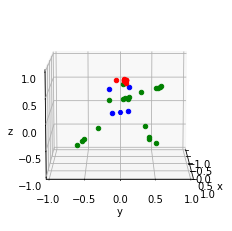

In [19]:
draw_mediapipe(json_object, 222)

## **Mixamo Bone Name** 

In [ ]:
mixamo_bone_name= [
    'Hips, 0, -1',
    'Spine, 1, 0',
        'Spine1, 2, 1',
            'Spine2, 3, 2',

                'Neck, 4, 3',
                    'Head, 5, 4',

                'LeftArm, 6,3',
                    'LeftForeArm, 7, 6',
                        'LeftHand, 8,7',
                            'LeftHandThumb1, 9, 8',
                            'LeftHandIndex1, 10, 9',
                            'LeftHandPinky1, 11, 10',

                'RightArm, 12, 3',
                    'RightForeArm, 13, 12',
                        'RightHand, 14, 13',
                            'RightHandThumb1, 15, 14',
                            'RightHandIndex1, 16, 15',
                            'RightHandPinky1, 17, 16',
    'LeftLeg, 18, 0',
        'LeftUpLeg, 19, 18',
            'LeftFoot, 20, 19'
    'RightLeg, 21, 0',
        'RightUpLeg, 22, 21',
            'LeftFoot, 23, 22'
]